# Hydroclimatic hazard - crop progress
- Author: Eunkyoung Choi (kyoung.choi@colostate.edu)
- Version: March, 2022

In [1]:
### Import packages
import numpy as np
import pandas as pd
import scipy.io
#import geopandas as gpd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms
from linearmodels.panel import PanelOLS
import seaborn as sns; sns.set()
#import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')
import plotly.figure_factory as ff
import plotly.graph_objects as go
import plotly.express as px
#import cmocean #put in camp = 'cmo.amp'
from sklearn.metrics import r2_score
#from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit

# 1) Option:

In [116]:
### options:
'''
- crop_name: 'Maize', 'Soybeans', 'Spring Wheat', 'Sorghum'
- time_period: the last year of our study period
- data_cut: due to limited data, we choose states which have at least 1/3 of the study period.
'''

crop_name = 'Spring Wheat'

time_period = 2020

data_cut = 1/3

In [117]:
################################### Custom Functions #########################################################################
'''
- exclude_growing phases: growing phases that states have inconsistent data.
'''
if crop_name == 'Maize':
    crop_type = ['CORN','CORN, GRAIN']
    growing = ['PLANTED','EMERGED','SILKING','DOUGH','DENTED','MATURE','HARVESTED']
    exclude_growing = ['MILK','SEEDBED PREPARED']
    crop_file_name = 'maize'
elif crop_name == 'Soybeans':
    growing = ['PLANTED','EMERGED','BLOOMING','SETTING PODS','DROPPING LEAVES','HARVESTED']
    exclude_growing = ['FULLY PODDED','COLORING','MATURE', 'SEEDBED PREPARED']
    crop_file_name = 'soybeans'
elif crop_name == 'Spring Wheat':
    crop_type = ['WHEAT, SPRING, (EXCL DURUM)']
    growing = ['PLANTED','EMERGED','HEADED','HARVESTED']
    exclude_growing = ['JOINTING','COLORING','BOOTED','MATURE']
    crop_file_name = 'spring_wheat'
elif crop_name == 'Sorghum':
    crop_type = ['SORGHUM','SORGHUM, GRAIN']
    growing = ['PLANTED','EMERGED','HEADED','COLORING','MATURE','HARVESTED']
    exclude_growing = ['SEEDBED PREPARED']
    crop_file_name = 'sorghum'

sel_cols = ['Program', 'Year', 'Period', 'Week Ending', 'Geo Level', 'State','State ANSI', 'County','County ANSI','Data Item','Value']


# 2) Crop progress data
## 2-1) import data

In [118]:
if crop_name == 'Maize':
    crop_data = pd.read_csv('USDA_NASS_Maize_progress_1981_2020_weekly_downloaded_28Mar2022.csv', usecols=sel_cols, index_col=[0])
elif crop_name == 'Soybeans':
    crop_data = pd.read_csv('USDA_NASS_Soybeans_progress_1981_2020_weekly_downloaded_28Mar2022.csv', usecols=sel_cols, index_col=[0])
elif crop_name == 'Spring Wheat':
    crop_data = pd.read_csv('USDA_NASS_Spring and Winter Wheat_progress_1981_2020_weekly_downloaded_28Mar2022.csv', usecols=sel_cols, index_col=[0])
elif crop_name == 'Sorghum':
    crop_data = pd.read_csv('USDA_NASS_Sorghum_progress_1981_2020_weekly_downloaded_28Mar2022.csv', usecols=sel_cols, index_col=[0])

crop_data.dtypes

Year             int64
Period          object
Week Ending     object
Geo Level       object
State           object
State ANSI       int64
County         float64
County ANSI    float64
Data Item       object
Value            int64
dtype: object

In [119]:
#### adjusting formats:
if crop_name in ('Maize','Sorghum','Spring Wheat'):
    crop_data['crop_type'] = crop_data['Data Item'].astype(str).str.split(" - ", n=1, expand=True)[0]
    print(crop_data['crop_type'].unique())
    crop_data = crop_data.loc[crop_data['crop_type'].isin(crop_type)]
    crop_data = crop_data[['Year','Period','Week Ending','State','State ANSI','crop_type','Data Item','Value']]
    print(crop_data['crop_type'].unique())
else:
    print('no')
    print(crop_data['Data Item'].unique())
crop_data['Week Ending'] = pd.to_datetime(crop_data['Week Ending'])

['WHEAT, SPRING, (EXCL DURUM)']
['WHEAT, SPRING, (EXCL DURUM)']


In [120]:
#### check null values:
crop_data.loc[crop_data.Value.isnull()]

Empty DataFrame
Columns: [Year, Period, Week Ending, State, State ANSI, crop_type, Data Item, Value]
Index: []

## 2-2) Extracting growing phase names

In [121]:
## seperate growing phase names from data item
crop_data['growing_phase'] = crop_data['Data Item'].astype(str).str.split("T ", n=1, expand=True)[1]
print(crop_data['growing_phase'].unique())
crop_data.head()

['PLANTED' 'EMERGED' 'JOINTING' 'HEADED' 'BOOTED' 'COLORING' 'MATURE'
 'HARVESTED']


Year    Period Week Ending         State  State ANSI  \
Program                                                         
SURVEY   2020  WEEK #14  2020-04-05         IDAHO          16   
SURVEY   2020  WEEK #14  2020-04-05     MINNESOTA          27   
SURVEY   2020  WEEK #14  2020-04-05       MONTANA          30   
SURVEY   2020  WEEK #14  2020-04-05        OREGON          41   
SURVEY   2020  WEEK #14  2020-04-05  SOUTH DAKOTA          46   

                           crop_type  \
Program                                
SURVEY   WHEAT, SPRING, (EXCL DURUM)   
SURVEY   WHEAT, SPRING, (EXCL DURUM)   
SURVEY   WHEAT, SPRING, (EXCL DURUM)   
SURVEY   WHEAT, SPRING, (EXCL DURUM)   
SURVEY   WHEAT, SPRING, (EXCL DURUM)   

                                                 Data Item  Value  \
Program                                                             
SURVEY   WHEAT, SPRING, (EXCL DURUM) - PROGRESS, MEASUR...     23   
SURVEY   WHEAT, SPRING, (EXCL DURUM) - PROGRESS, MEASUR...      0   
SURVEY   WHEAT, SPRING, (EXCL DURUM) - PROGRESS, MEASUR...      1   
SURVEY   WHEAT, SPRING, (EXCL DURUM) - PROGRESS, MEASUR...     45   
SURVEY   WHEAT, SPRING, (EXCL DURUM) - PROGRESS, MEASUR...      0   

        growing_phase  
Program                
SURVEY        PLANTED  
SURVEY        PLANTED  
SURVEY        PLANTED  
SURVEY        PLANTED  
SURVEY        PLANTED

## 2-3) Data quality & threshold

In [122]:
################################### Custom Functions #########################################################################
def cal_count(data):
    print(data[['growing_phase','Year','State']].drop_duplicates().groupby(['growing_phase'])['Year'].count())
    count = data[['growing_phase','Year','State','Value']].groupby(['State','growing_phase','Year'])['Value'].count().reset_index()
    return count, count.pivot(index=['State','growing_phase'],columns='Year',values='Value')


In [123]:
## check number of datapoints per year and growing phase:
state_year_count = cal_count(crop_data)
state_year_count[1]

growing_phase
BOOTED        12
COLORING      35
EMERGED      244
HARVESTED    243
HEADED       244
JOINTING      23
MATURE        15
PLANTED      244
Name: Year, dtype: int64


Year                        1981  1982  1983  1984  1985  1986  1987  1988  \
State        growing_phase                                                   
COLORADO     COLORING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             EMERGED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HARVESTED       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HEADED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
IDAHO        EMERGED         3.0   6.0   5.0   6.0   7.0   7.0   5.0   6.0   
             HARVESTED       7.0   8.0   7.0   6.0   9.0  11.0   7.0   4.0   
             HEADED          7.0   7.0   7.0   6.0   5.0   4.0   4.0   5.0   
             PLANTED         5.0   7.0   7.0   7.0   6.0   8.0   5.0   7.0   
MINNESOTA    COLORING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             EMERGED         3.0   6.0   5.0   6.0   7.0   7.0   5.0   6.0   
             HARVESTED       7.0   8.0   7.0   7.0  10.0  11.0   9.0   5.0   
             HEADED          7.0   7.0   7.0   6.0   5.0   5.0   4.0   5.0   
             JOINTING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         5.0   6.0   7.0   7.0   6.0   8.0   5.0   7.0   
MONTANA      BOOTED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             COLORING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             EMERGED         3.0   6.0   5.0   6.0   6.0   7.0   4.0   6.0   
             HARVESTED       7.0   7.0   6.0   6.0  10.0  10.0   7.0   5.0   
             HEADED          5.0   5.0   5.0   5.0   5.0   5.0   4.0   5.0   
             PLANTED         5.0   7.0   7.0   7.0   6.0   8.0   5.0   7.0   
NEVADA       EMERGED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HEADED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
NORTH DAKOTA COLORING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             EMERGED         3.0   6.0   5.0   6.0   6.0   7.0   5.0   6.0   
             HARVESTED       7.0   8.0   7.0   7.0  10.0  10.0   8.0   5.0   
             HEADED          7.0   7.0   6.0   6.0   5.0   5.0   4.0   5.0   
             JOINTING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             MATURE          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         5.0   7.0   7.0   7.0   5.0   8.0   5.0   7.0   
OREGON       EMERGED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HARVESTED       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HEADED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
SOUTH DAKOTA COLORING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             EMERGED         3.0   6.0   5.0   6.0   7.0   7.0   5.0   6.0   
             HARVESTED       7.0   8.0   7.0   7.0  10.0  11.0   9.0   5.0   
             HEADED          7.0   7.0   6.0   6.0   5.0   5.0   4.0   5.0   
             JOINTING        NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             MATURE          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         5.0   7.0   6.0   7.0   6.0   8.0   5.0   7.0   
UTAH         EMERGED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HARVESTED       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HEADED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
WASHINGTON   EMERGED         NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HARVESTED       NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             HEADED          NaN   NaN   NaN   NaN   NaN   NaN   NaN   NaN   
             PLANTED  

In [1]:
# Visual plot to check data quality
for state in state_year_count[0].reset_index().State.unique():
    data_plot = state_year_count[0].reset_index().loc[state_year_count[0].reset_index().State == state]
    fig, ax = plt.subplots(1,1, figsize=(20,10))
    for key, grp in data_plot.reset_index().groupby('Year'):
        ax.scatter(grp['growing_phase'], grp['Value'], label=key)
        
    plt.legend(fontsize=14, loc="upper right", bbox_to_anchor=(1.44, 1), ncol=5)
    ax.set_ylabel('data count', fontsize=20)
    ax.set_xlabel('growing phases', fontsize=20)
    ax.xaxis.set_tick_params(labelsize=17,color='black')
    ax.set_title(str(state),fontsize=25)
    plt.show()

In [125]:
## year count per state and growing phase
count_cut = state_year_count[0].groupby(['State','growing_phase'])['Year'].count().reset_index()

## get a list of states which do not have more than 1/3* time_length (1981-2020) here:
time_threshold = data_cut * len(crop_data['Year'].unique())
remove_state = count_cut.loc[(~count_cut['growing_phase'].isin(exclude_growing)) & (count_cut['Year'] < time_threshold)]['State'].unique()
remove_state

array(['COLORADO', 'NEVADA', 'OREGON', 'UTAH', 'WYOMING'], dtype=object)

In [126]:
### get states from data availability threshold:
crop = crop_data.loc[~crop_data['State'].isin(remove_state)]
print('yes states:', len(crop['State'].unique()), 'no states:', len(remove_state))

crop['week_num'] = crop['Period'].astype(str).str.split(" #", n=1, expand=True)[1].astype(int)

###  remove the unncessary growing phases from the dataset:
crop = crop.loc[~crop['growing_phase'].isin(exclude_growing)]


yes states: 6 no states: 5


In [127]:
del crop_data, state_year_count, remove_state, count_cut, time_threshold

# 3) Climatological crop progress

## 3-1) Formatting:
- Reformating the week # 1-10 of the harvest phase
- crop planted density: convert % (original data "Value") to fraction (for a logistic function)
- get min, max, count of crop planted ensity per state-year-growing phase


In [128]:
## Reformating the week #1-10 of the harvest phase which comes from the previous year's growing cycle:
if crop.loc[((crop['growing_phase'] == 'HARVESTED') & (crop['week_num'] <10))].shape[0] > 0:
    print('Reformating the week #1-10 of the harvest phase:')
    crop.loc[((crop['growing_phase'] == 'HARVESTED') & (crop['week_num'] <10)), 'week_num'] = crop.loc[((crop['growing_phase'] == 'HARVESTED') & (crop['week_num'] <10))]['week_num'] + 52
    ## move 52+a harvested data to the previous year's data:
    crop.loc[((crop['growing_phase'] == 'HARVESTED') & (crop['week_num'] >52)),'Year']  == crop.loc[((crop['growing_phase'] == 'HARVESTED') & (crop['week_num'] >52))]['Week Ending'].dt.year -1
else:
    None
    

In [129]:
## Reformating data:
crop['Value'] = crop['Value'] / 100
crop['value_min'] = crop.groupby(['State','Year','growing_phase'])['Value'].transform(min)
crop['value_max'] = crop.groupby(['State','Year','growing_phase'])['Value'].transform(max)
crop['value_count'] = crop.groupby(['State','Year','growing_phase'])['Value'].transform('count')
crop['week_num_ref'] = pd.to_datetime(crop['Week Ending']).dt.week

## 3-2) data quality & filtering

In [130]:
excluded_df = pd.DataFrame()
## for condition 3:
temp = crop.loc[(crop['value_max'] == 1.0) & (crop['Value'] < 1)].groupby(['State','Year','growing_phase'])['Value'].nunique().reset_index()

if crop.loc[(crop['value_min'] > 0.95)].groupby(['State','Year','growing_phase'])['Value'].nunique().shape[0] >0:
    print('more than 0.95')
    excluded_df = excluded_df.append(crop.loc[(crop['value_min'] > 0.95)].groupby(['State','Year','growing_phase'])['Value'].nunique().reset_index())
    excluded_df = excluded_df.loc[excluded_df['Value'] < 3].copy()
if crop.loc[((crop['value_max'] <= 0.35) & (crop['value_count'] == 1))].shape[0] > 0:
    print('less than 0.35')
    excluded_df = excluded_df.append(crop.loc[((crop['value_max'] <= 0.35) & (crop['value_count'] == 1))][['State','Year','growing_phase','Value']].drop_duplicates())
if temp.shape[0] > 0:
    print('dominating 1')
    excluded_df = excluded_df.append(temp.loc[temp['Value'] < 2])

excluded_df = excluded_df.drop(columns=['Value']).drop_duplicates()
excluded_df['to_remove'] = 'Yes'
excluded_df

dominating 1


State  Year growing_phase to_remove
110  SOUTH DAKOTA  1981       EMERGED       Yes
137  SOUTH DAKOTA  1988        HEADED       Yes

In [131]:
### finalizing the dataframe:
if excluded_df.shape[0] >0:
    print('excluding conditions exist')
    crop = pd.merge(crop, excluded_df, on=['State','Year','growing_phase'], how='left')
    crop = crop.loc[crop['to_remove'] != 'No'].copy().drop(columns=['to_remove'])
else:
    print('excluding conditions do not exist')
    None

excluding conditions exist


## 3-3) Assigning method: logistic or interpolation


In [132]:
### a) Assigning 'interpolation/50%' to states with crop planted density including 0.5
### Filtering rows based on given conditions
condition_a = (crop['value_min'] <= 0.50) & (crop['value_max'] >= 0.5) & (crop['value_count'] != 1)
crop.loc[condition_a, 'calender_method'] = 'interpolation/50%'

### b) Assigning 'logistic' to the remaining rows and excluding rows where 'value_count' is 1
print(crop.loc[crop['value_count'] == 1].shape)
crop = crop.loc[~((crop['value_count'] == 1) & (crop['calender_method'].isnull()))]
crop['calender_method'].fillna('logistic', inplace=True)

(0, 15)


## 3-4) climatological values:

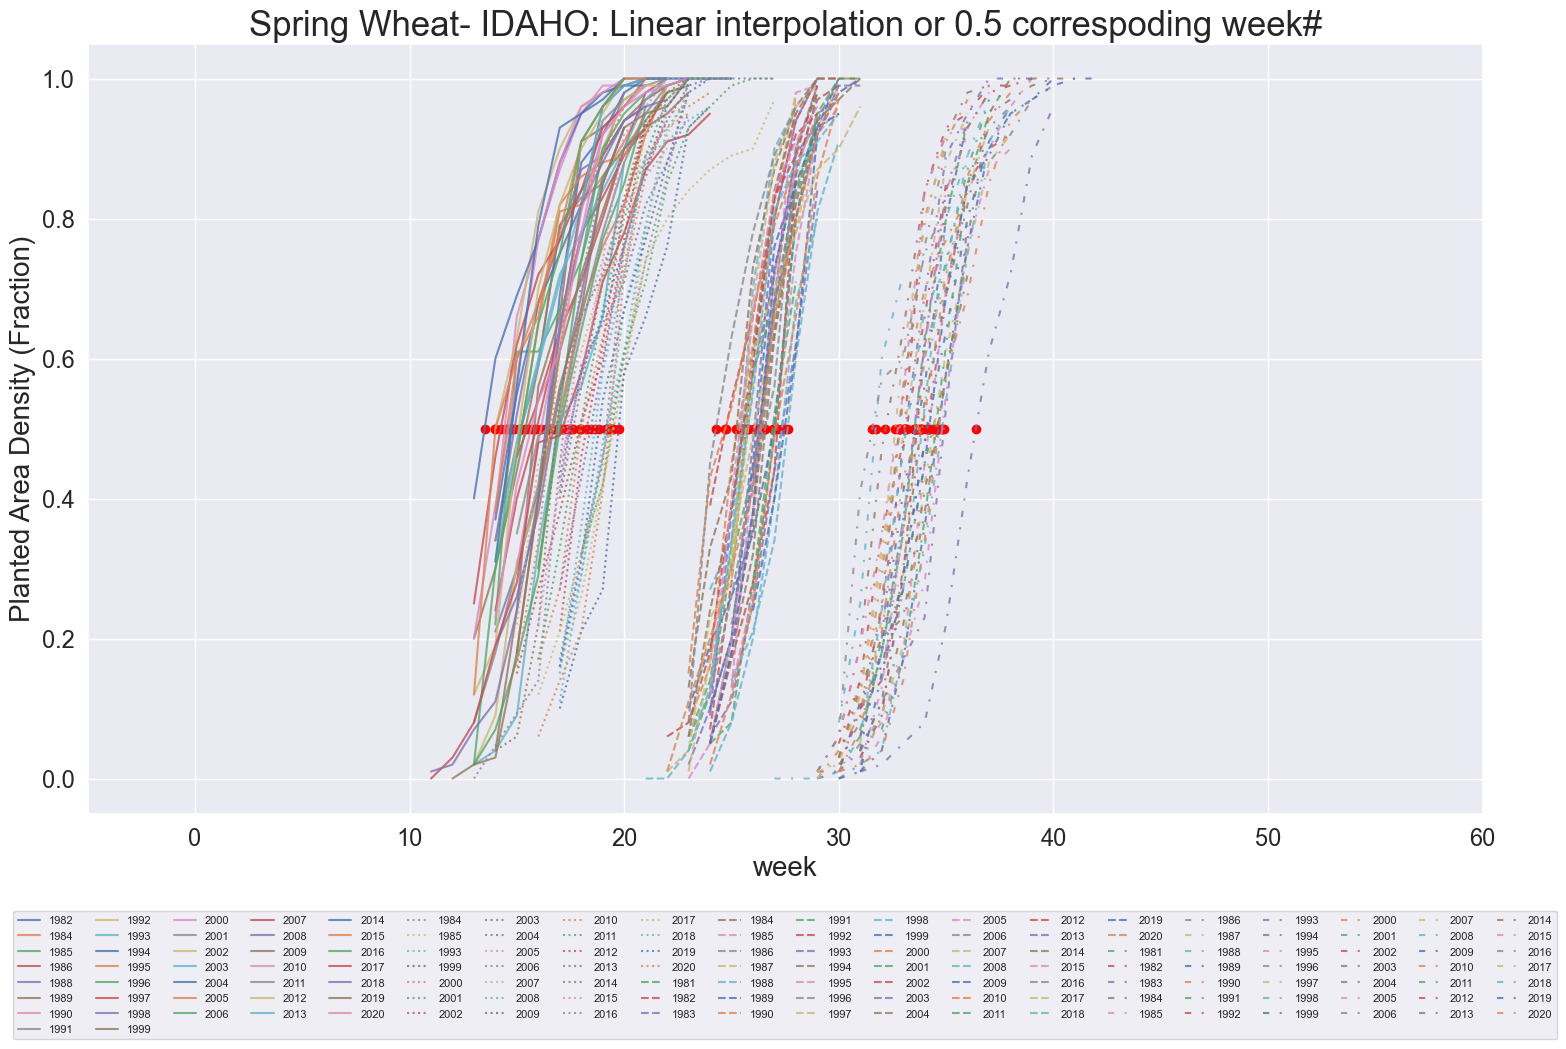

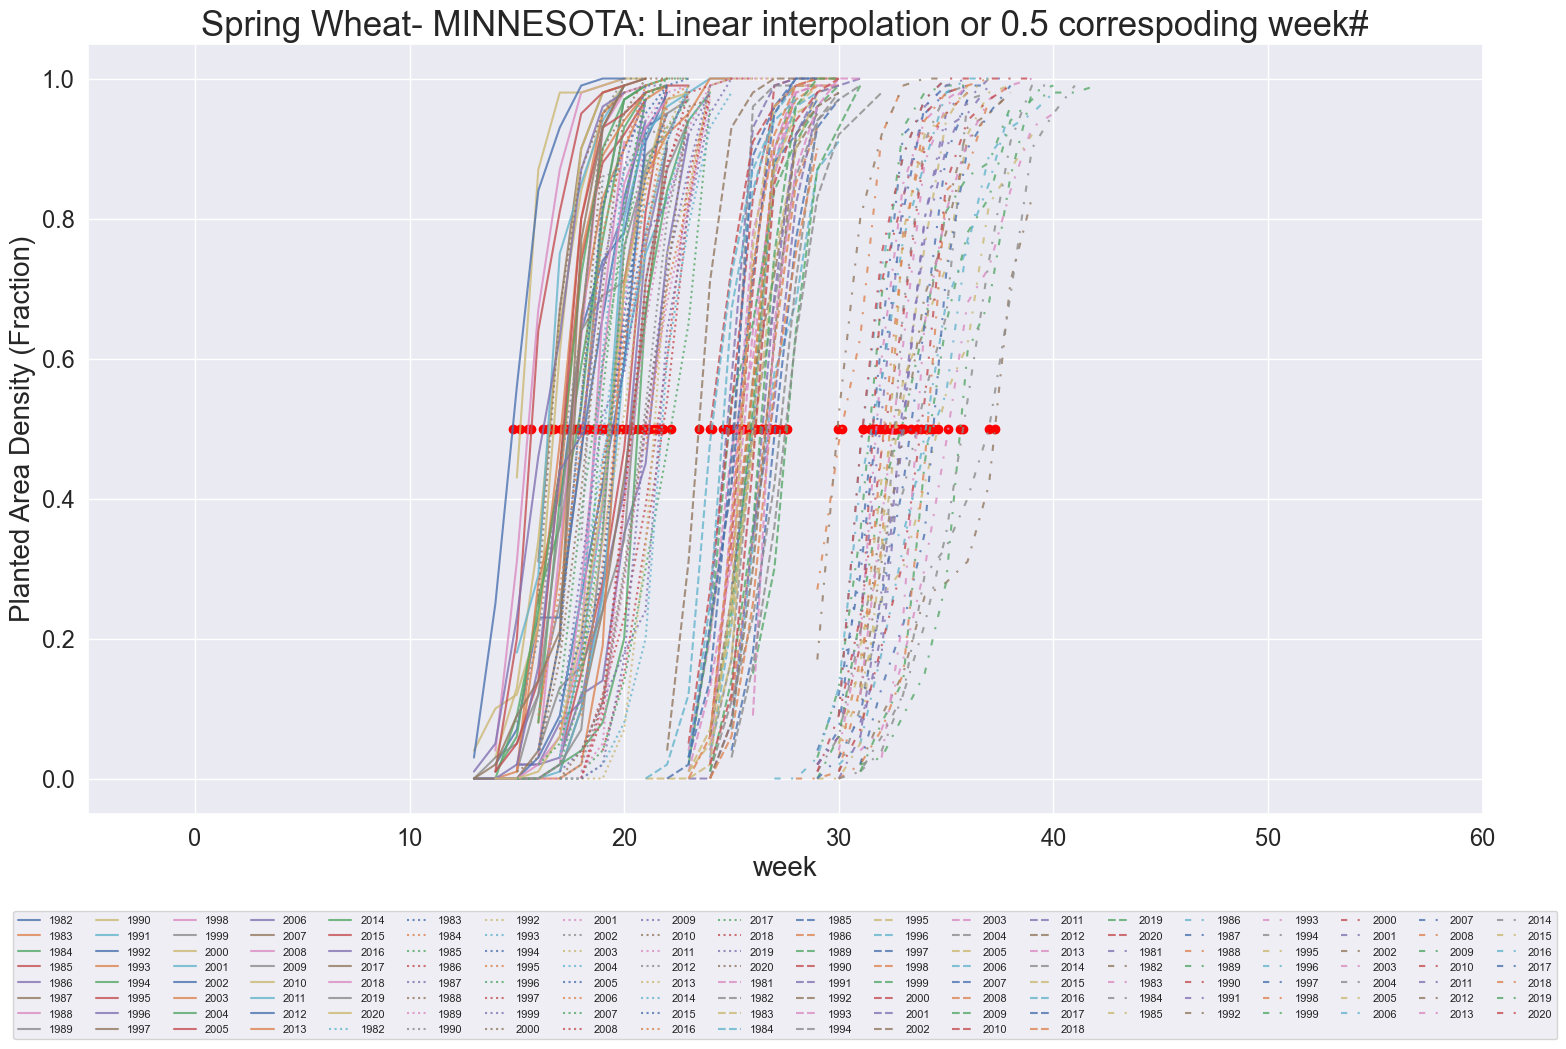

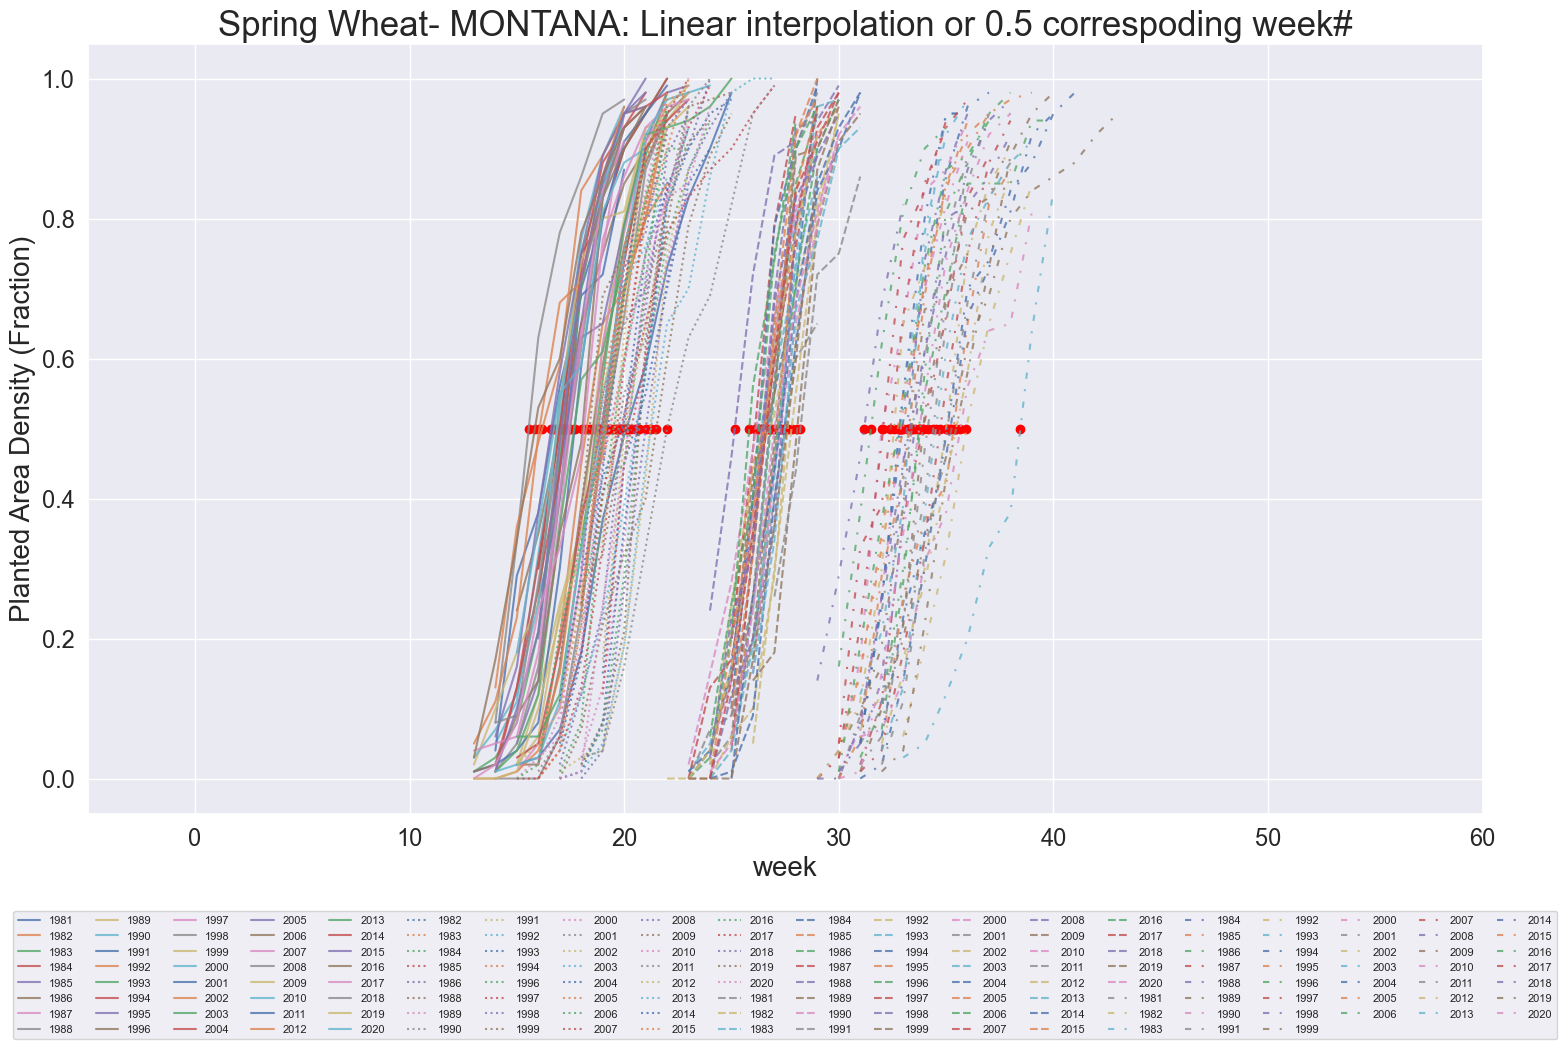

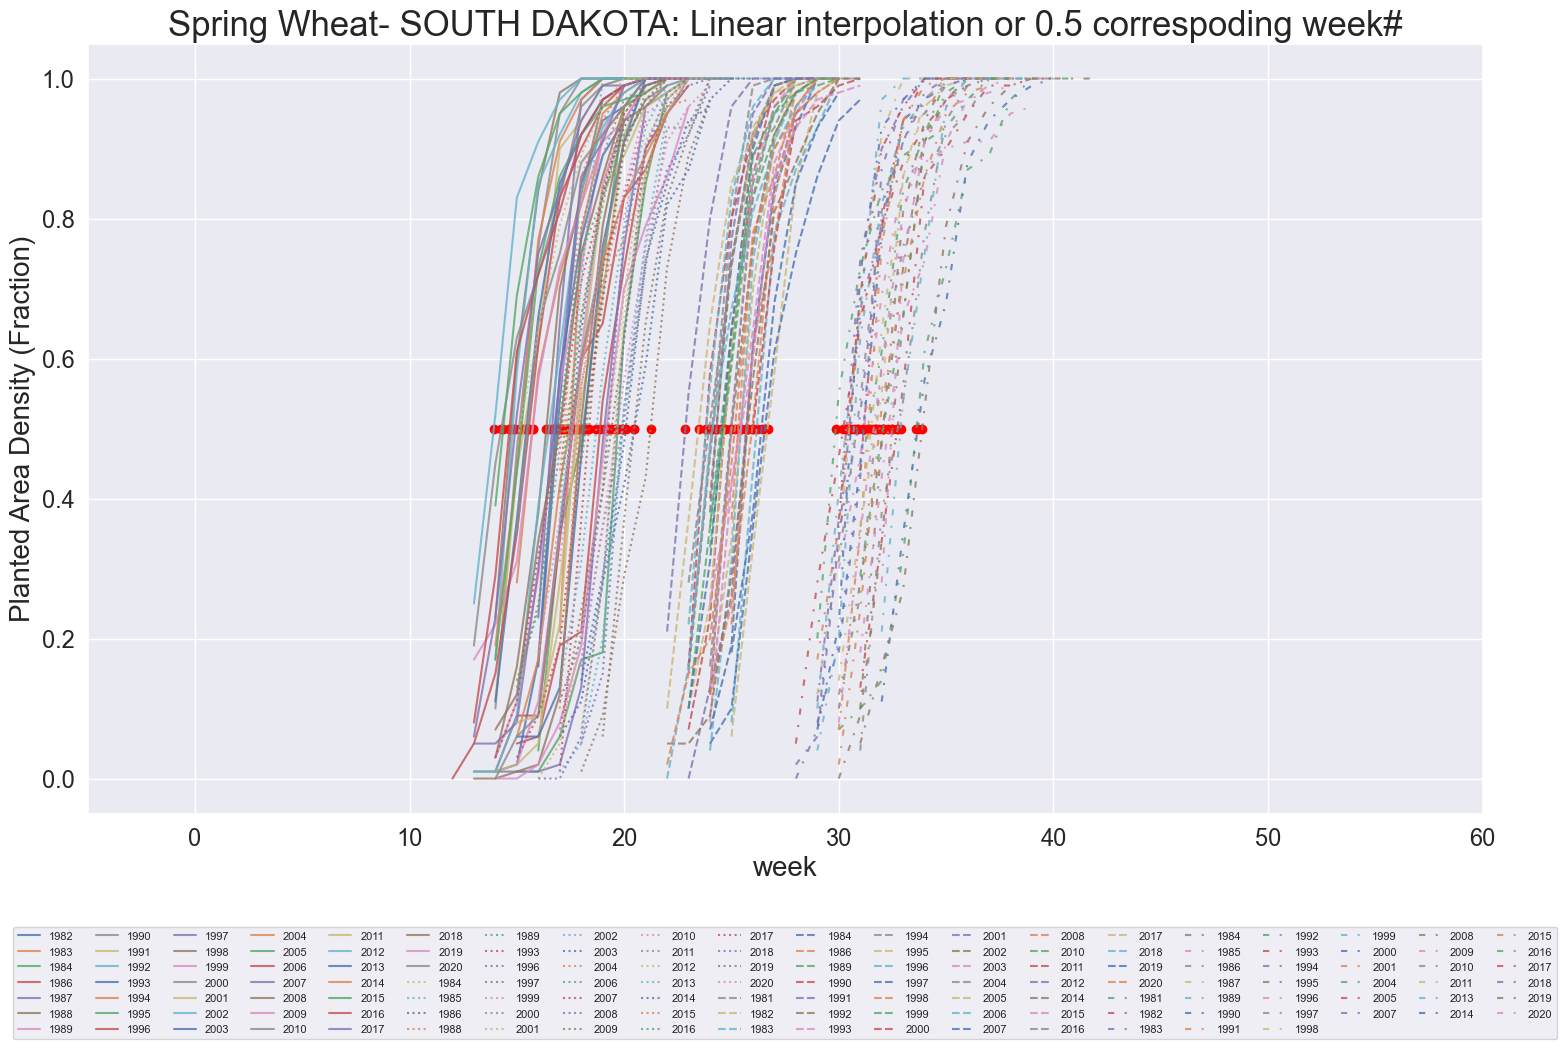

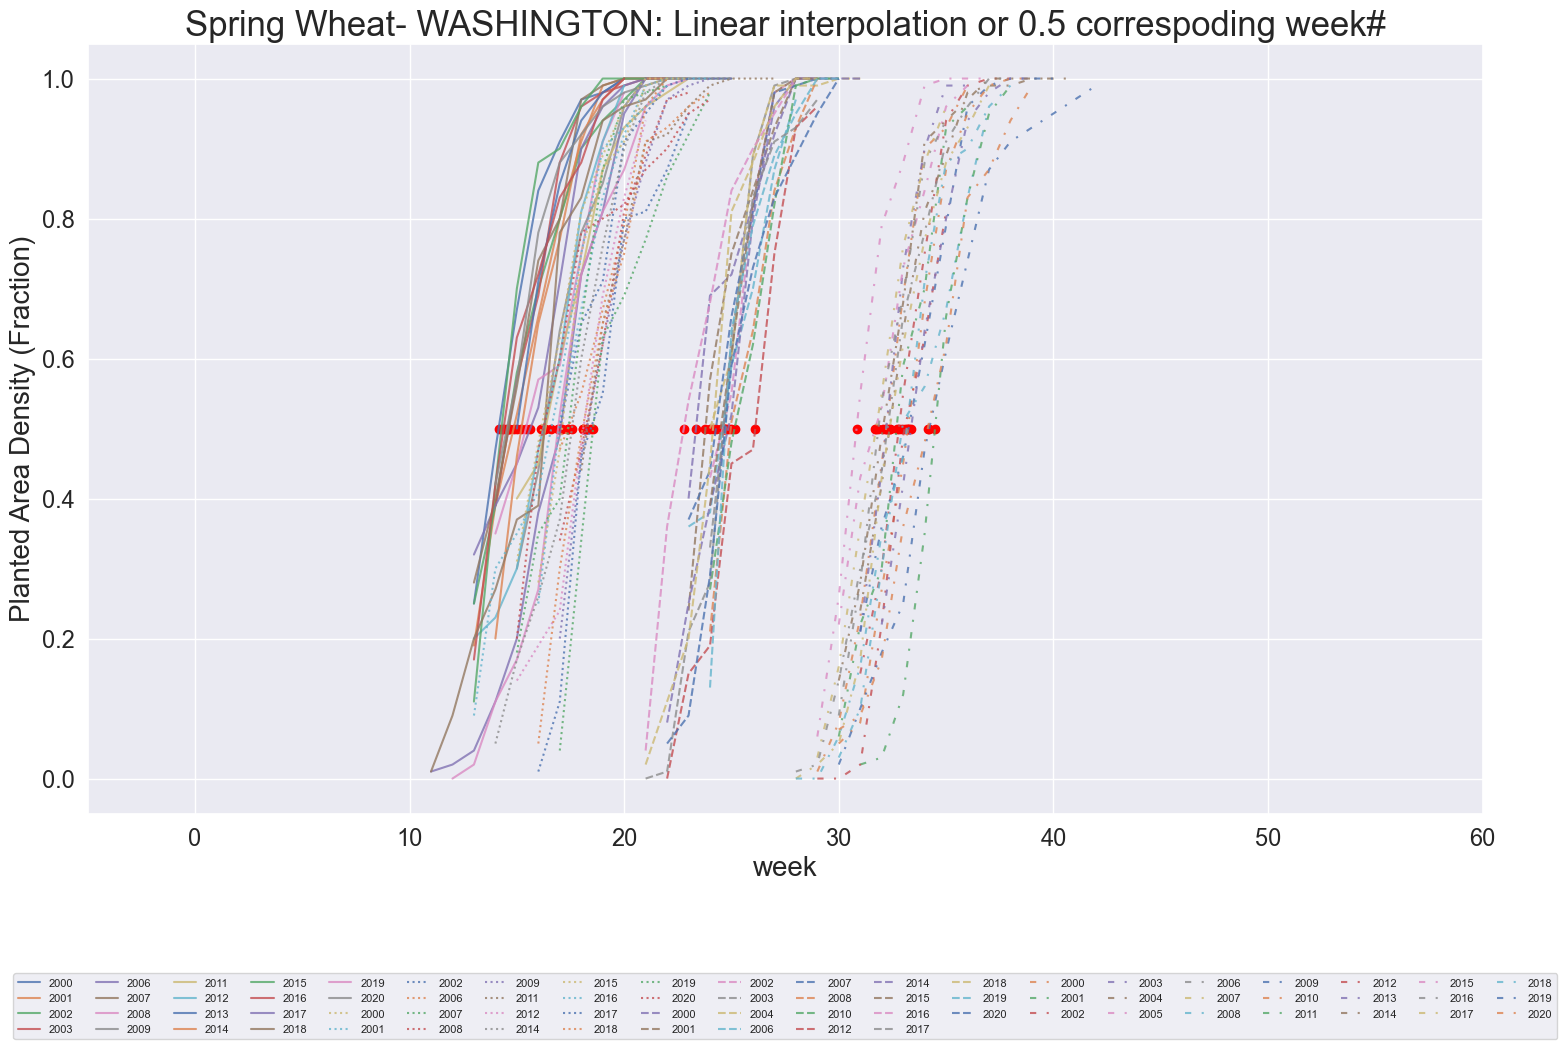

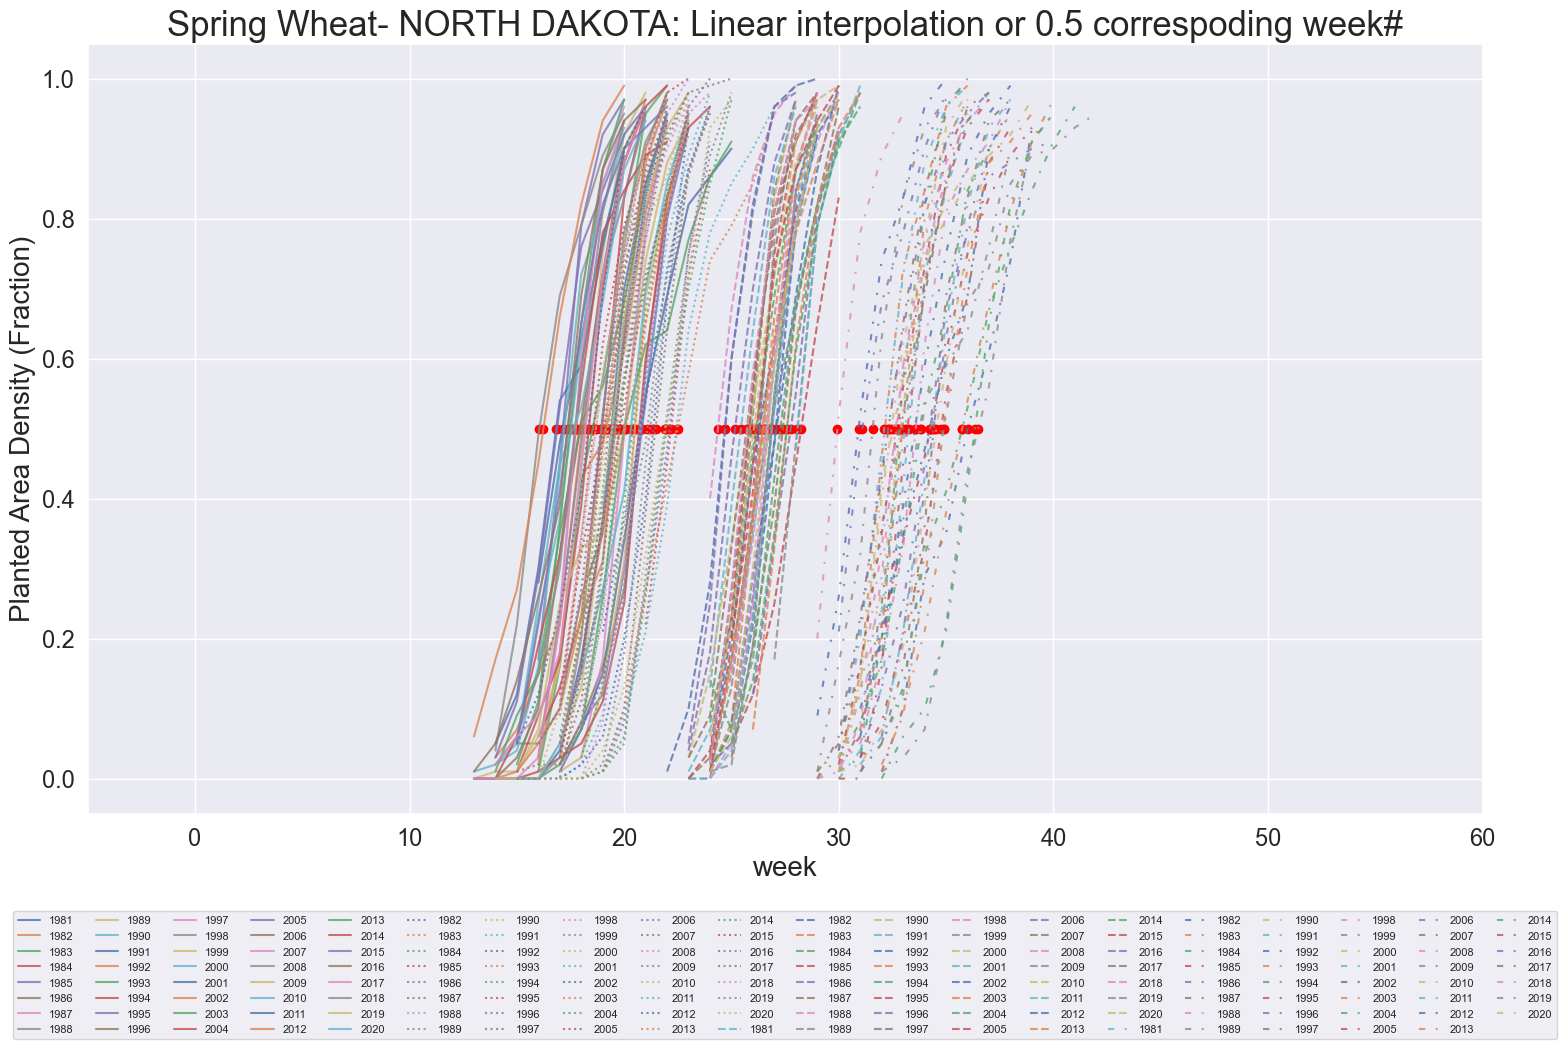

In [133]:
## variable/dataset:
week_50_hyb = pd.DataFrame()
curve_fit_hyb = pd.DataFrame()

## plot
linestyle_tuple = [('line','solid'),('dt','dotted'),('dashed','dashed'),('dashdot',(0, (3, 5, 1, 5))),('loosely',(0, (1, 10))),('loosely',(0, (5, 10))),('loosely',(0, (3, 10, 1, 10)))]

### linear interpolation:
linear_crop = crop.loc[crop['calender_method'] == 'interpolation/50%'][['State','Year','growing_phase','Week Ending','week_num','Value']]

for state in linear_crop['State'].unique():
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    for idx, phase in enumerate(growing):
        data = linear_crop.loc[(linear_crop['State'] == state) & (linear_crop['growing_phase'] == phase)]
        for key, grp in data.groupby('Year'):
            grp = grp.sort_values('week_num')
            week_50_val = np.interp(0.5, grp['Value'].values, grp['week_num'].values)
            week_50_hyb = week_50_hyb.append(pd.DataFrame.from_dict({'State_name':state,'growing_phase':phase,
                                                    'Year':np.unique(grp['Year']), 'week_50':week_50_val,'method':'interpolation'}))
            grp.plot(x='week_num',y='Value', ax=ax, label=key, alpha=0.8, linestyle=linestyle_tuple[idx][1])
            ax.scatter(x=week_50_val, y=0.5, color='red')
        ax.set_xlim(-5,60)
        ax.legend(fontsize=8, loc="lower center",bbox_to_anchor=(0.5,-0.3), ncol=20)
        ax.set_ylabel('Planted Area Density (Fraction)', fontsize=20)
        ax.set_xlabel('week', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=17,color='black')
        ax.yaxis.set_tick_params(labelsize=17,color='black')
        ax.set_title(crop_name +'- '+state+': Linear interpolation or 0.5 correspoding week#',fontsize=25)

    #plt.savefig(crop_file_name+'/'+crop_file_name+'_linear_interpolation_50%_'+state) 
    plt.show()
del linear_crop
del data

In [134]:
def logifunc(x, x0, k):
    return 1.0 / (1.0 + np.exp(-(k*x+x0)))

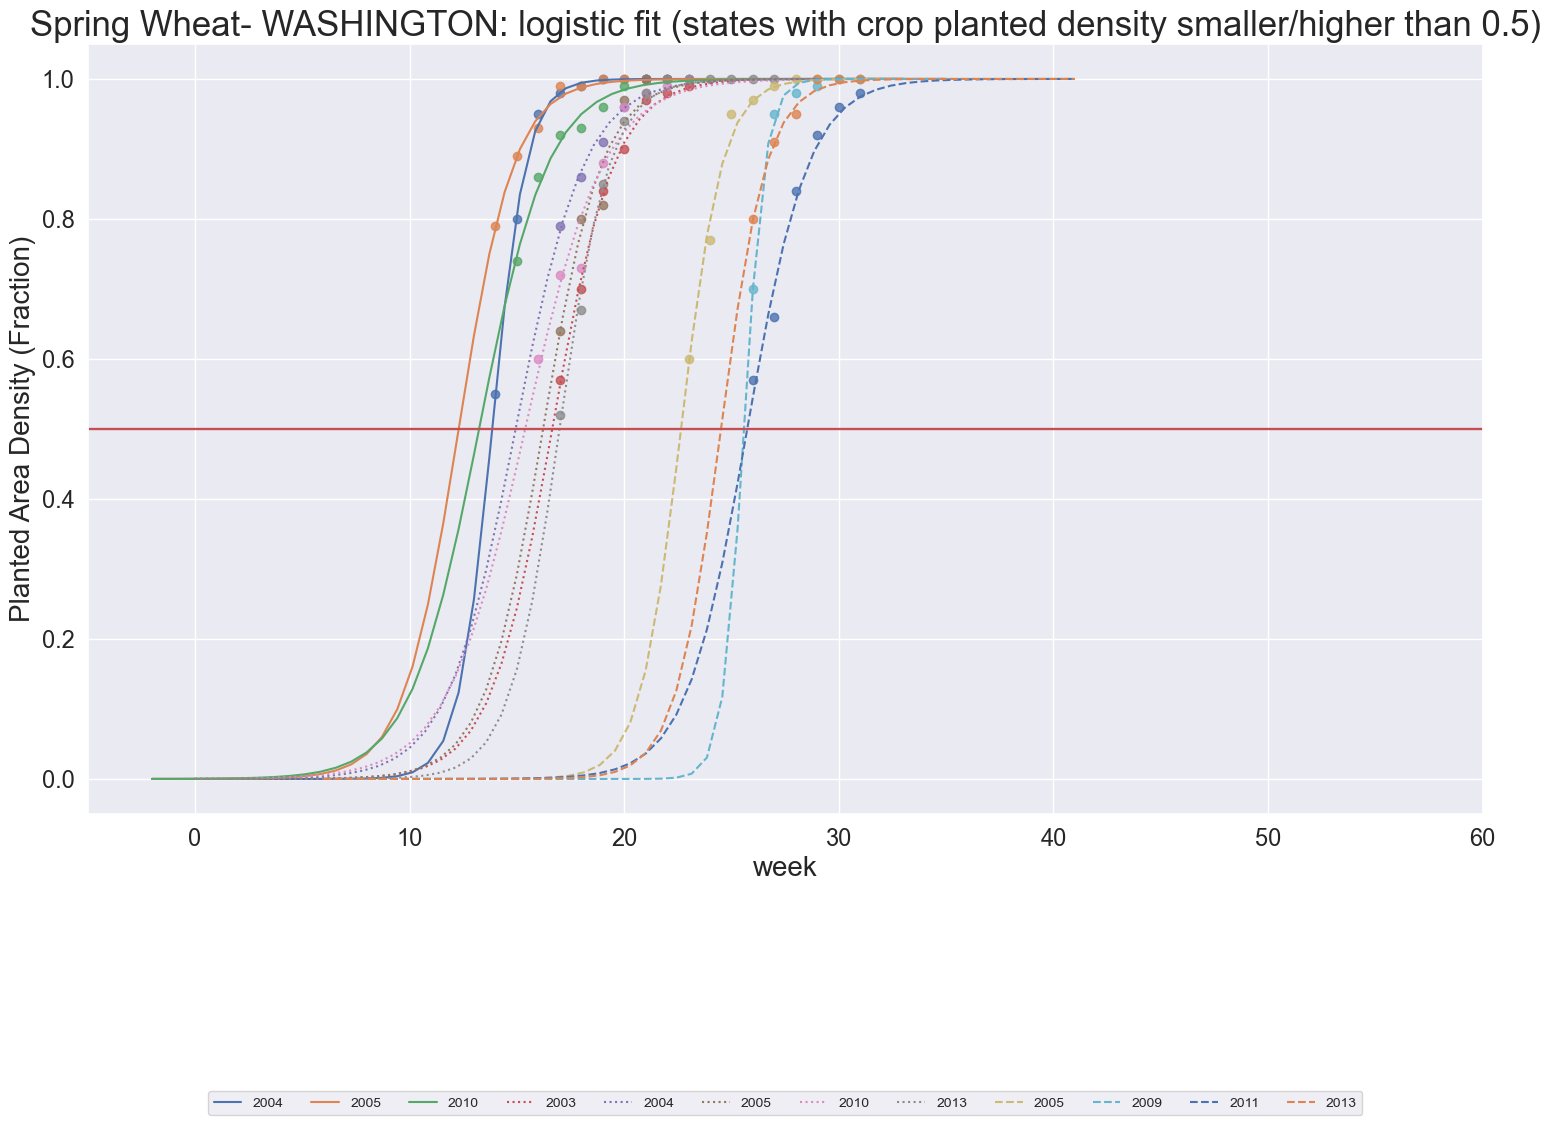

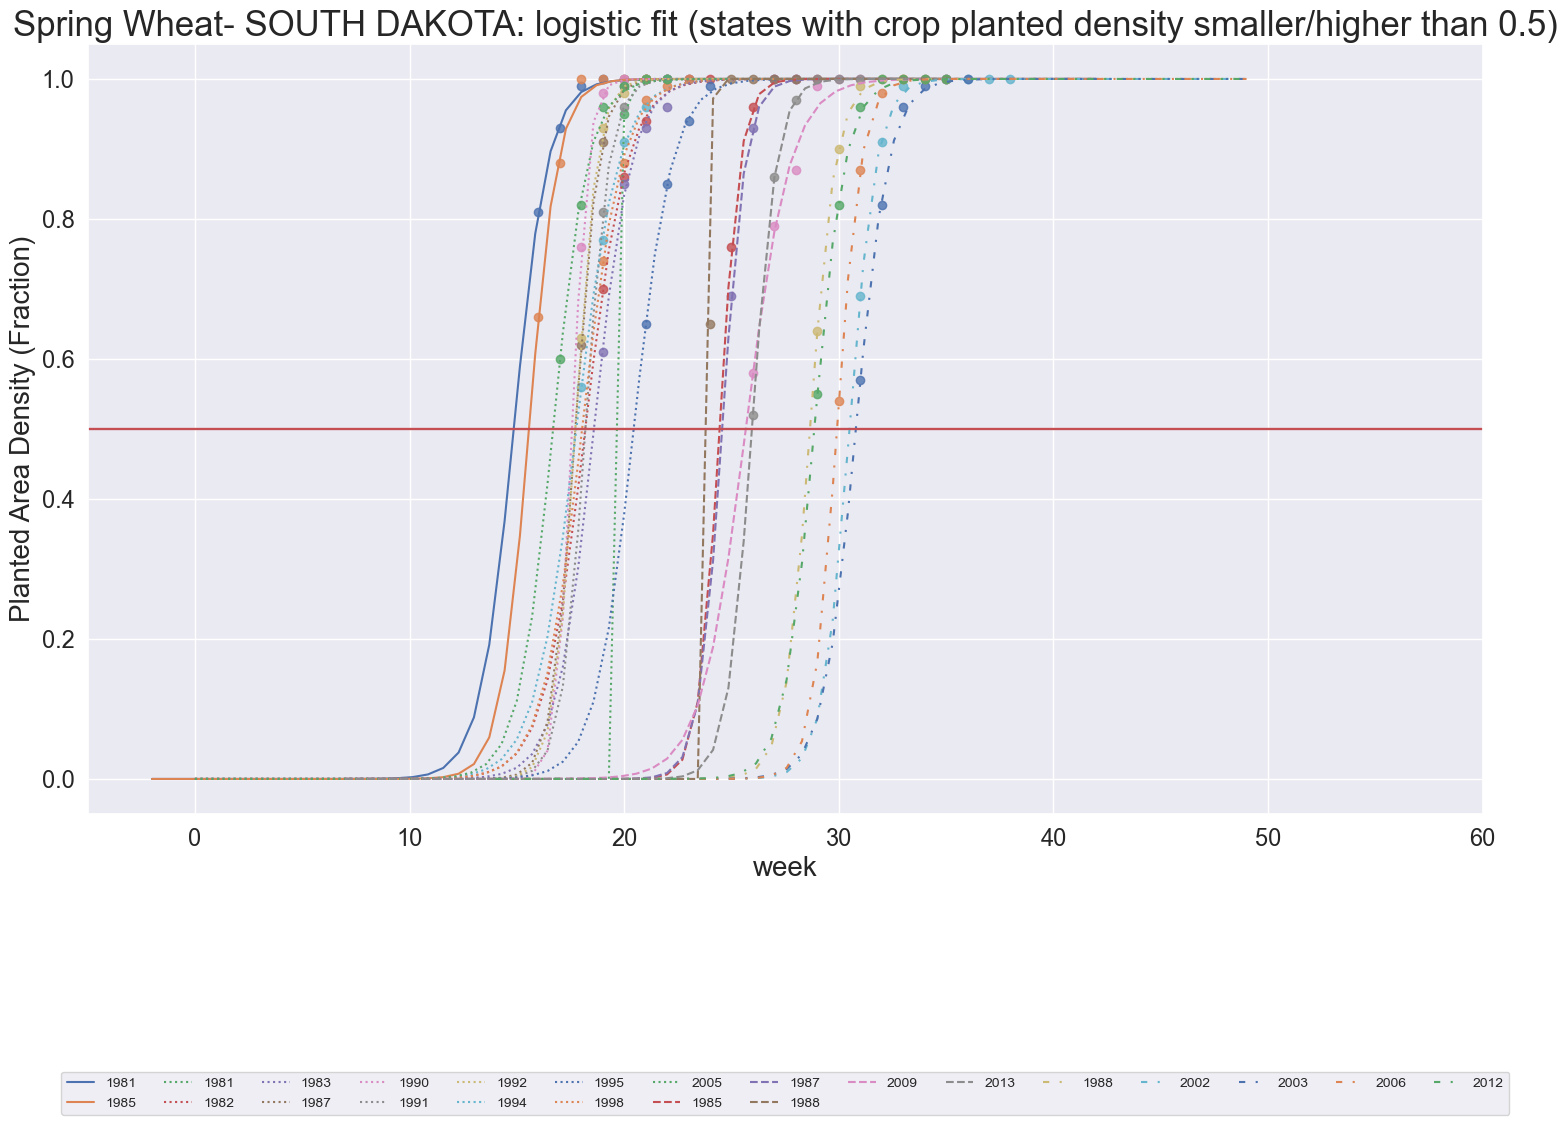

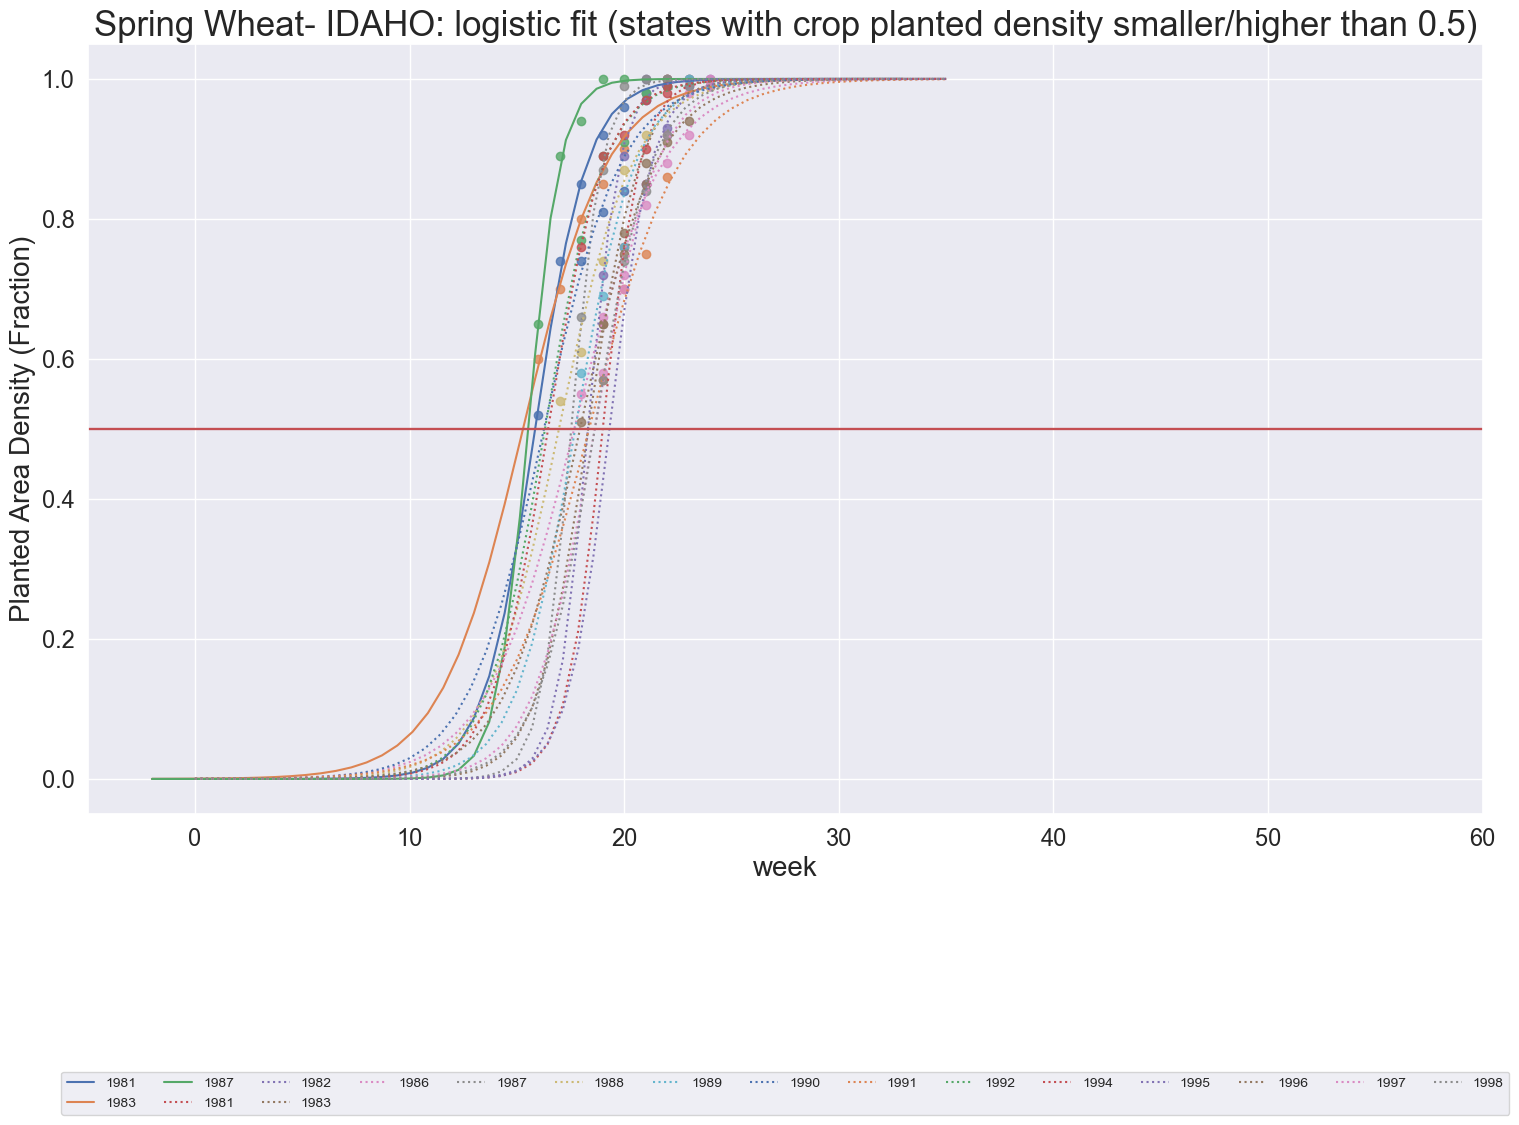

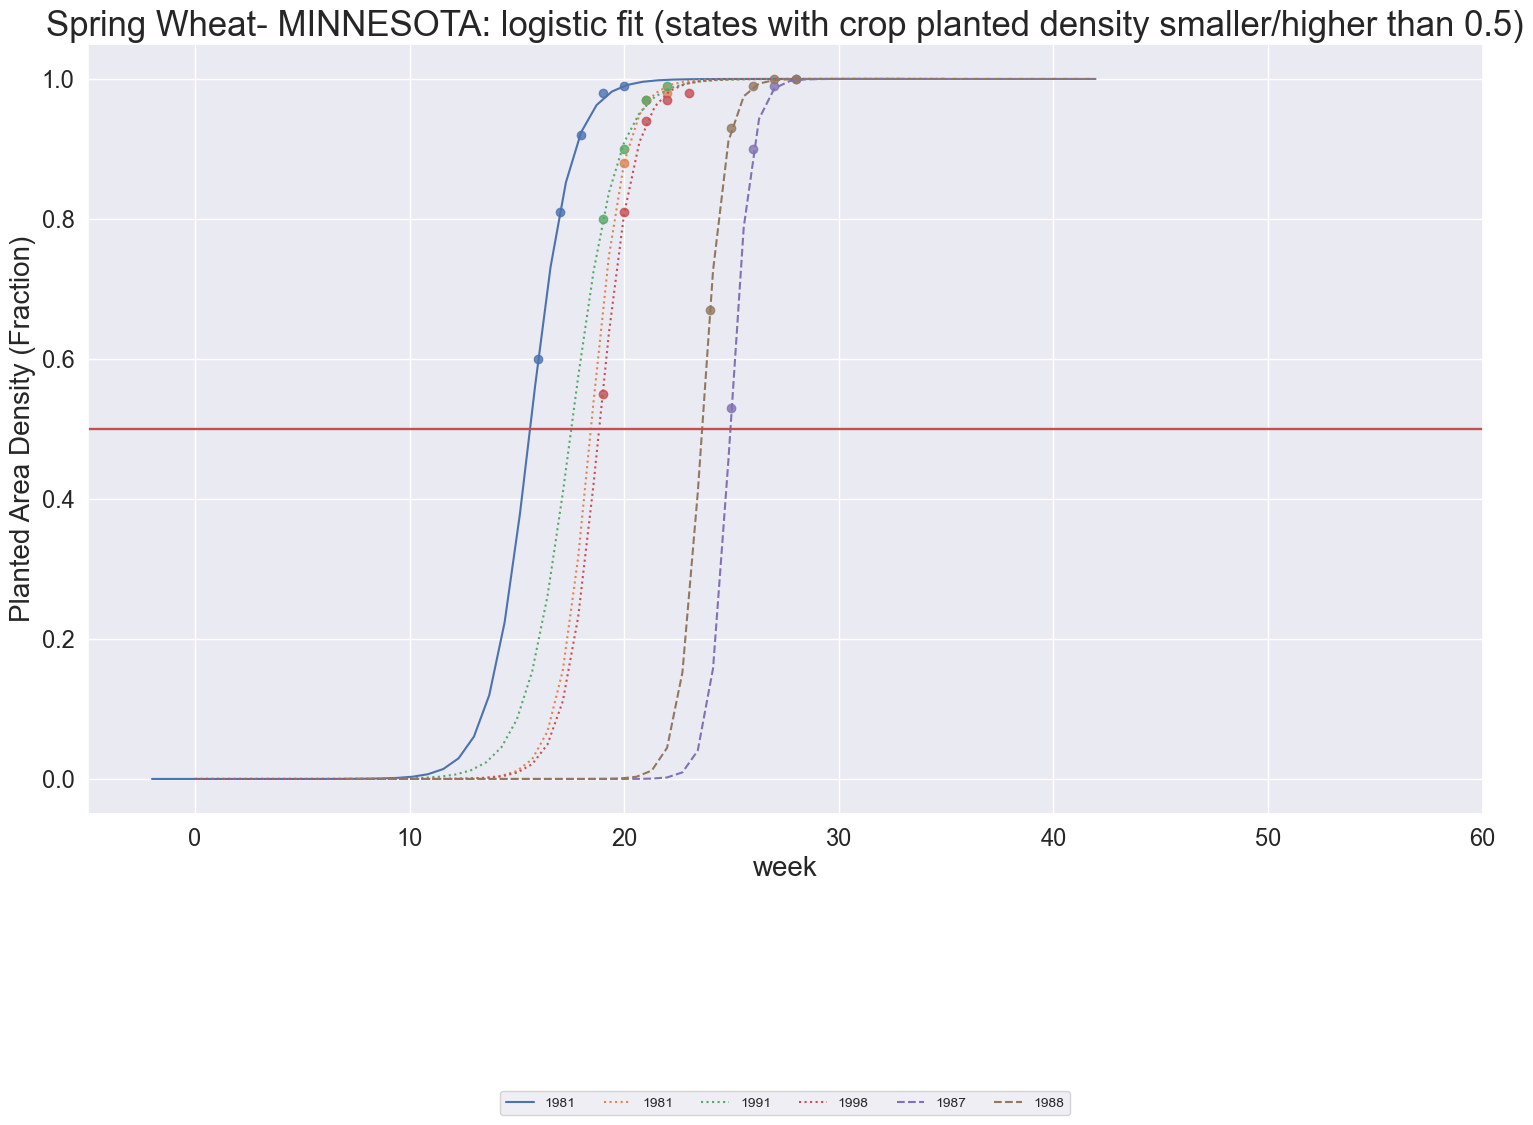

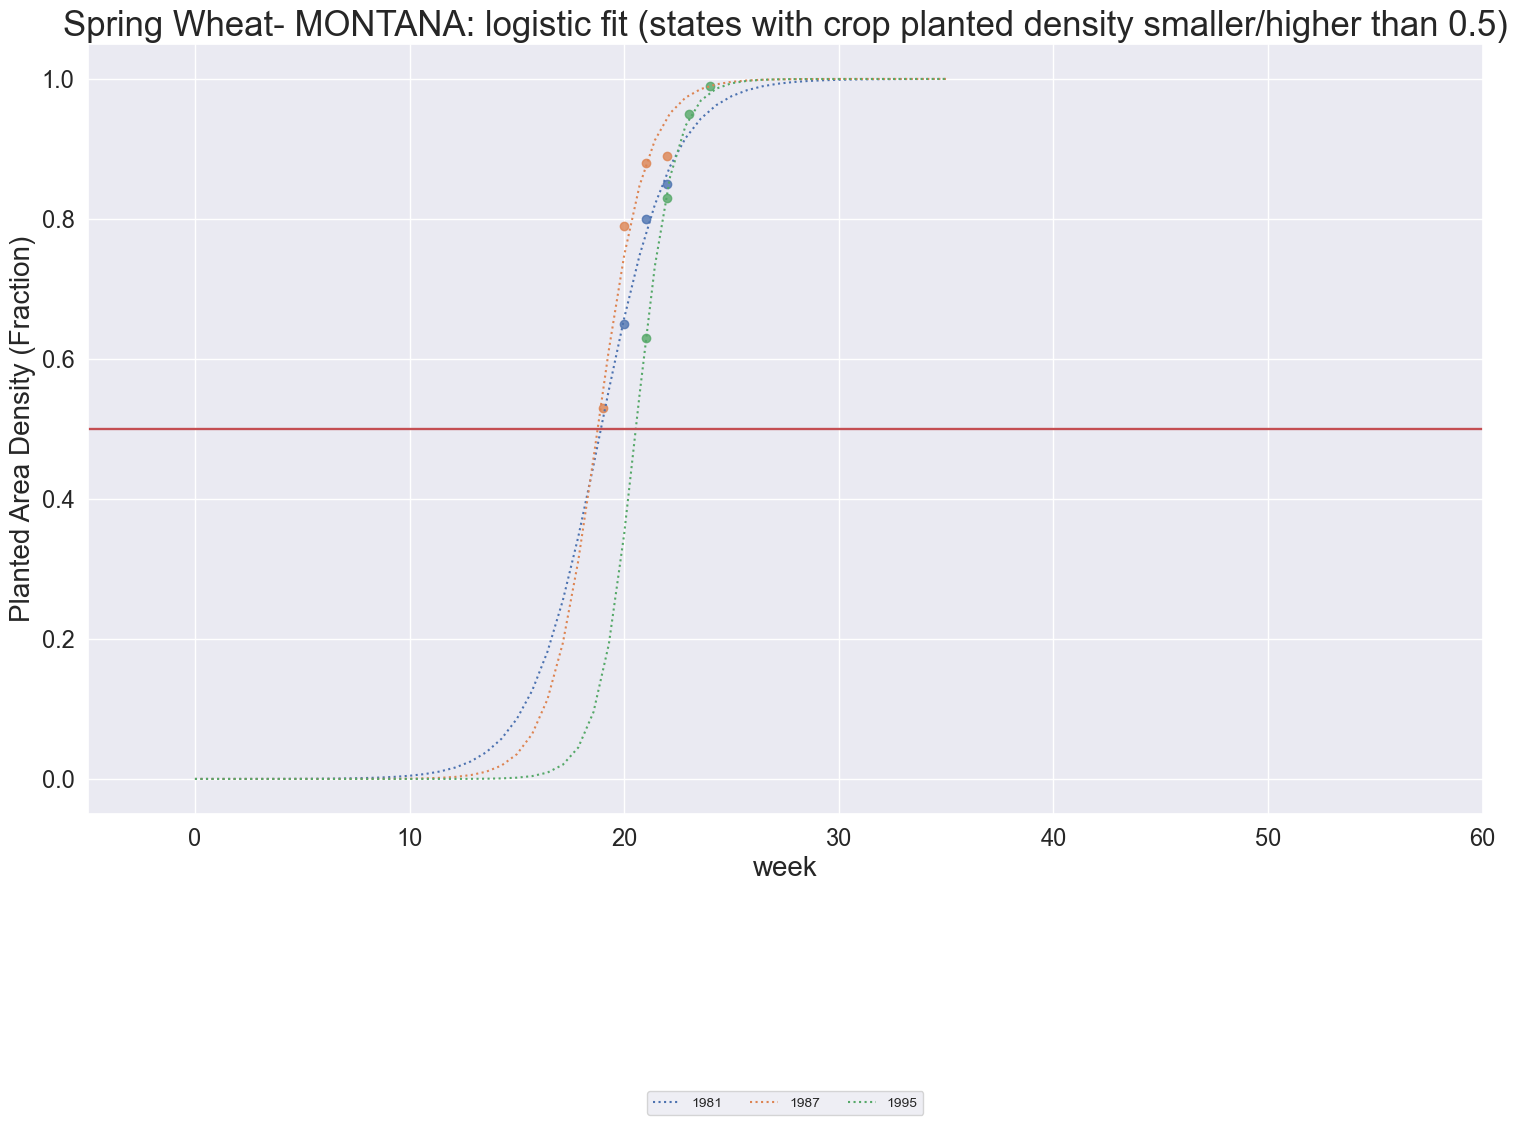

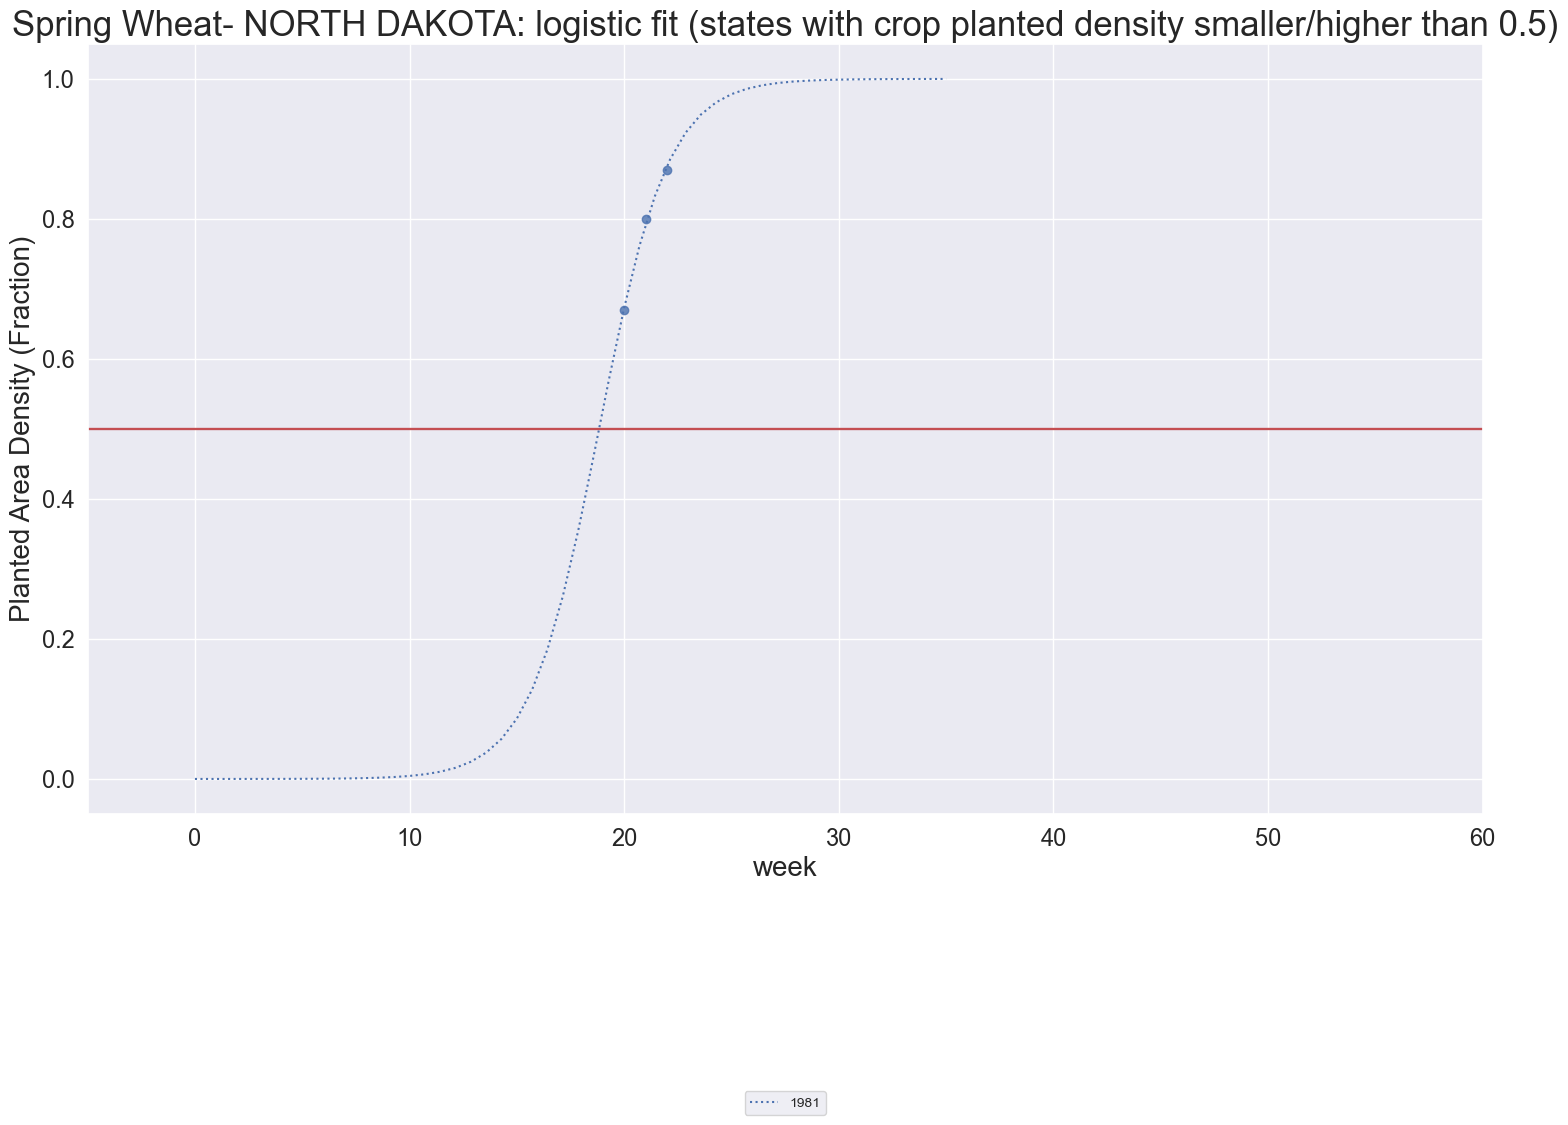

In [135]:
## logistic fit:
logi_inter = crop.loc[crop['calender_method'] == 'interpolation/50%'].groupby(['State','growing_phase'])['week_num'].quantile(0.5, interpolation='nearest').reset_index()

logi_inter['gs_count'] = logi_inter.groupby(['State'])['growing_phase'].transform('nunique')

if logi_inter.loc[logi_inter['gs_count'] < len(growing)].shape[0] >0:
    print('state having missing reference date')
    missing_state = logi_inter.loc[logi_inter['gs_count'] < len(growing)]['State'].values
    missing_gs = list(set(growing).difference(set(logi_inter.loc[logi_inter['State'] == missing_state]['growing_phase'].values)))
    previous_gs = growing[growing.index(missing_gs[0]) -1]
    print(missing_state, missing_gs, previous_gs )
    ref_num = crop.loc[(crop['State'] == missing_state[0]) & (crop['growing_phase'] == previous_gs) & (crop['Value'] > 0.89)]['week_num'].min()
    logi_inter = logi_inter.append(
        {'State':missing_state,'growing_phase':missing_gs[0],'week_num':ref_num}, ignore_index=True)
    del missing_state, missing_gs, previous_gs, ref_num
else:
    None
         
logi_crop = crop.loc[crop['calender_method'] == 'logistic'][['State','Year','growing_phase','Week Ending','week_num','Value']]            

for state in logi_crop['State'].unique():
    #print(state)
    fig, ax = plt.subplots(1,1, figsize=(18,10))
    for idx, phase in enumerate(growing):
        data1 = logi_crop.loc[(logi_crop['State'] == state) & (logi_crop['growing_phase'] == phase)]
        standard_week = logi_inter.loc[(logi_inter['State']==state) & (logi_inter['growing_phase']==phase)]['week_num'].values
        for key, grp in data1.groupby('Year'):
            ##original data
            ax.scatter(x=grp['week_num'],y=grp['Value'], alpha=0.8)
            ##fit the logistic reg - probability function:
            x00 = -(np.log(1) - (-0.5*standard_week[0]))
            popt, pcov = curve_fit(logifunc, grp['week_num'], grp['Value'], p0=[x00,0.5],maxfev=5000)
            week_50_val = (np.log(1) - popt[0]) / popt[1]
    
            ## full range plot
            test_x = np.linspace(standard_week[0] - 20,standard_week[0] +15,num=50)
            ax.plot(test_x, logifunc(test_x, *popt),linestyle=linestyle_tuple[idx][1], label=key)
            
            #print(week_50_val)
            week_50_hyb = week_50_hyb.append(pd.DataFrame.from_dict({'State_name':state,'growing_phase':phase,
                                                             'Year':np.unique(grp['Year']), 'week_50':week_50_val,'method':'logistic'}))

        ax.axhline(y = 0.5, color = 'r', linestyle = '-')
        ax.set_xlim(-5,60)
    
        ax.set_ylabel('Planted Area Density (Fraction)', fontsize=20)
        ax.set_xlabel('week', fontsize=20)
        ax.xaxis.set_tick_params(labelsize=17,color='black')
        ax.yaxis.set_tick_params(labelsize=17,color='black')
        ax.set_title(crop_name+'- '+state + ': logistic fit (states with crop planted density smaller/higher than 0.5)',fontsize=25)

    ax.legend(fontsize=10, loc="lower center",bbox_to_anchor=(0.5,-0.4), ncol=15)
    #plt.savefig(crop_file_name+'/'+ crop_file_name +"_logistic_fit_"+state)
    plt.show()
del data1, logi_crop

In [136]:
## final data:
## State name file download
state_name = pd.read_excel('../../../state_full_name_abb.xlsx')
state_name = state_name.rename(columns={'FIPS':'State_ID','Postal Code':'State','Name':'State_name'})
state_name['State_ID'] = state_name['State_ID'].astype(str).str.zfill(2)
state_name['State_name'] = state_name['State_name'].str.upper()

week_50_df = pd.merge(week_50_hyb, state_name, on=['State_name'], how='left')
week_50_df['week_50'] = week_50_df['week_50'].round(0).astype(int)
week_50_df

State_name growing_phase  Year  week_50         method State State_ID
0           IDAHO       PLANTED  1982       16  interpolation    ID       16
1           IDAHO       PLANTED  1984       17  interpolation    ID       16
2           IDAHO       PLANTED  1985       17  interpolation    ID       16
3           IDAHO       PLANTED  1986       16  interpolation    ID       16
4           IDAHO       PLANTED  1988       15  interpolation    ID       16
..            ...           ...   ...      ...            ...   ...      ...
879     MINNESOTA        HEADED  1988       24       logistic    MN       27
880       MONTANA       EMERGED  1981       19       logistic    MT       30
881       MONTANA       EMERGED  1987       19       logistic    MT       30
882       MONTANA       EMERGED  1995       21       logistic    MT       30
883  NORTH DAKOTA       EMERGED  1981       19       logistic    ND       38

[884 rows x 7 columns]

In [39]:
### saving!:
week_50_df.to_csv('crop_calendar_'+crop_file_name+'_yearly_50%_planted_density_correspoinding_week_number_2014_2020_hybrid_method_28Mar2022.csv')

# 4) Plotting (Supplementary Figure S15)

In [137]:
n_colors = 42-12+1
colors = px.colors.sample_colorscale("Viridis_r", [n/(n_colors -1) for n in range(n_colors)])
c= dict(zip(np.arange(12,43,1).astype(str), colors))


In [139]:
### plotting (supplementary fig)

dataa = week_50_df.groupby(['State','growing_phase'])['week_50'].quantile(0.5, interpolation='nearest').reset_index()

for phase in dataa['growing_phase'].unique():
    data_plot = dataa.loc[dataa.growing_phase == phase].sort_values(by='week_50')
    data_plot['week_50'] = data_plot['week_50'].astype(str)
    fig = px.choropleth(data_plot,locations='State', locationmode='USA-states', color="week_50",scope="usa",
                         color_discrete_map= c,
                    category_orders={'week#':data_plot['week_50'].astype(int).sort_values().unique().astype(str)})
    fig.update_layout(title={'text': crop_name+' hybrid method: 50% week): <br>'+str(phase)+ ' (Median)','y':0.9,'x':0.5})
    fig.add_scattergeo(
        locations=data_plot['State'],
        locationmode='USA-states',
        text=data_plot['State'],
        mode='text',textfont=dict(size=13,color="black"))
    #fig.write_image(crop_file_name+'_'+phase+'.png',width=600, height=500, scale=1.5)
    fig.show()